In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from scipy.stats import randint
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, recall_score, precision_score, f1_score, accuracy_score, classification_report

In [8]:
heart = pd.read_csv('heartFailure.csv')
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [9]:
heart.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

**Separating categorical and numerica columns**

In [10]:
category_features = [col for col in heart.columns if heart[col].dropna().apply(lambda x: isinstance(x, str)).all()]
numeric_features = [col for col in heart.columns if heart[col].dropna().apply(lambda x: isinstance(x, (int, float))).all()]

**Filling Missing Values with SimpleImputer**

In [11]:
cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='mean')
oneHot = OneHotEncoder()

In [13]:
fill = ColumnTransformer([('categorical_filling', cat_imputer, category_features),
                                ('numerical_filling', num_imputer, numeric_features)],
                               remainder='passthrough')
filled_value = fill.fit_transform(heart)

**Creating DataFrame out of filled values**

In [14]:
filled_df = pd.DataFrame(filled_value, columns=category_features+numeric_features).round(2)

**Making column appearance or order accoring to the original column patterns**

In [22]:
heart_df = filled_df[heart.columns]
heart_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40.0,M,ATA,140.0,289.0,0.0,Normal,172.0,N,0.0,Up,0.0
1,49.0,F,NAP,160.0,180.0,0.0,Normal,156.0,N,1.0,Flat,1.0
2,37.0,M,ATA,130.0,283.0,0.0,ST,98.0,N,0.0,Up,0.0
3,48.0,F,ASY,138.0,214.0,0.0,Normal,108.0,Y,1.5,Flat,1.0
4,54.0,M,NAP,150.0,195.0,0.0,Normal,122.0,N,0.0,Up,0.0


**Splitting x and y value**

In [23]:
X = heart_df.drop(columns=['HeartDisease'])
y = heart_df.HeartDisease.astype(int)

**Category Transform: Changing string value to numeric values**

In [24]:
transformer = ColumnTransformer([('cat_conversion', oneHot, category_features)],
                                remainder = 'passthrough')
transformed_data = transformer.fit_transform(X)

In [25]:
# Skimming floating values to 2-decimal places
transformed_x = pd.DataFrame(transformed_data).map(lambda col: round(col, 2) if isinstance(col, (int, float)) else col)

In [26]:
transformed_x.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,40.0,140.0,289.0,0.0,172.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,49.0,160.0,180.0,0.0,156.0,1.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,37.0,130.0,283.0,0.0,98.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,48.0,138.0,214.0,0.0,108.0,1.5
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,54.0,150.0,195.0,0.0,122.0,0.0


**Splitting train and test data**

In [27]:
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(transformed_x, y, test_size=0.2)

In [28]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.875

In [29]:
y_pred = clf.predict(X_test)

In [32]:
def model_evaluation(y_test, y_pred):
    print(f'AccuracyScor: {accuracy_score(y_test, y_pred)*100:.3f}%'),
    print(f'PrecisionScore: {precision_score(y_test, y_pred):.3f}'),
    print(f'RecallScore: {recall_score(y_test, y_pred):.3f}'),
    print(f'F1Score: {f1_score(y_test, y_pred):.3f}')
    print('\n')
    
    metrics = {'AccuracyScore': accuracy_score(y_test, y_pred),
               'PrecisionScore': precision_score(y_test, y_pred),
               'RecallScore': recall_score(y_test, y_pred),
               'F1Score': f1_score(y_test, y_pred)
              }
    return metrics

In [43]:
baseline_metrics = model_evaluation(y_test, y_pred)

AccuracyScor: 87.500%
PrecisionScore: 0.912
RecallScore: 0.869
F1Score: 0.890




**RandomizedSearchCV**

In [35]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [38]:
grids = {
    'n_estimators': randint(10, 1000),
    'max_depth': randint(3, 30),
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': randint(1, 20),
    'min_samples_split': randint(2, 25),
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}
rand_cv = RandomizedSearchCV(estimator=clf, param_distributions=grids, n_iter=25, scoring=None, cv=5, verbose=0, n_jobs=-1)
rand_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=25,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x178b06720>,
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x178b06c30>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x178b06de0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x178be5fa0>})

In [39]:
best_param = rand_cv.best_params_
best_param

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 17,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 15,
 'n_estimators': 830}

In [40]:
y_preds = rand_cv.predict(X_test)

In [42]:
random_cv = model_evaluation(y_test, y_preds)

AccuracyScor: 86.957%
PrecisionScore: 0.895
RecallScore: 0.879
F1Score: 0.887




**GridSearchCV**

In [49]:
grid_param = {
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'n_estimators': [560, 830, 950],
    'max_depth': [13, 17, 21],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [2, 7],
    'min_samples_split': [12, 15, 19]
}
grid_cv = GridSearchCV(estimator=clf, param_grid=grid_param, cv=5, scoring=None, verbose=0, n_jobs=-1)
grid_cv.fit(X_train, y_train)

/Users/nareshdhami/Desktop/MachineLearning/env/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [13, 17, 21],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [2, 7],
                         'min_samples_split': [12, 15, 19],
                         'n_estimators': [560, 830, 950]})

In [51]:
best_params = grid_cv.best_params_
best_params

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 13,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 12,
 'n_estimators': 560}

In [52]:
y_preds_grid = grid_cv.predict(X_test)

In [53]:
grid_search = model_evaluation(y_test, y_preds_grid)

AccuracyScor: 89.130%
PrecisionScore: 0.914
RecallScore: 0.897
F1Score: 0.906




**Comparing all Metrices**

In [62]:
compare_metrics = pd.DataFrame({
    'Baseline Metrics': baseline_metrics,
    'RandomizedSearchCV': random_cv,
    'GridSearchCV': grid_search
})
compare_metrics

,Baseline Metrics,RandomizedSearchCV,GridSearchCV
AccuracyScore,0.875000,0.869565,0.891304
PrecisionScore,0.911765,0.895238,0.914286
RecallScore,0.869159,0.878505,0.897196
F1Score,0.889952,0.886792,0.905660


In [63]:
long_metrics = compare_metrics.reset_index().melt(id_vars='index', var_name='Metrics', value_name='Score')
long_metrics.rename(columns={'index':'Model'}, inplace=True)
long_metrics

,Model,Metrics,Score
0,AccuracyScore,Baseline Metrics,0.875000
1,PrecisionScore,Baseline Metrics,0.911765
2,RecallScore,Baseline Metrics,0.869159
3,F1Score,Baseline Metrics,0.889952
4,AccuracyScore,RandomizedSearchCV,0.869565
5,PrecisionScore,RandomizedSearchCV,0.895238
6,RecallScore,RandomizedSearchCV,0.878505
7,F1Score,RandomizedSearchCV,0.886792
8,AccuracyScore,GridSearchCV,0.891304
9,PrecisionScore,GridSearchCV,0.914286


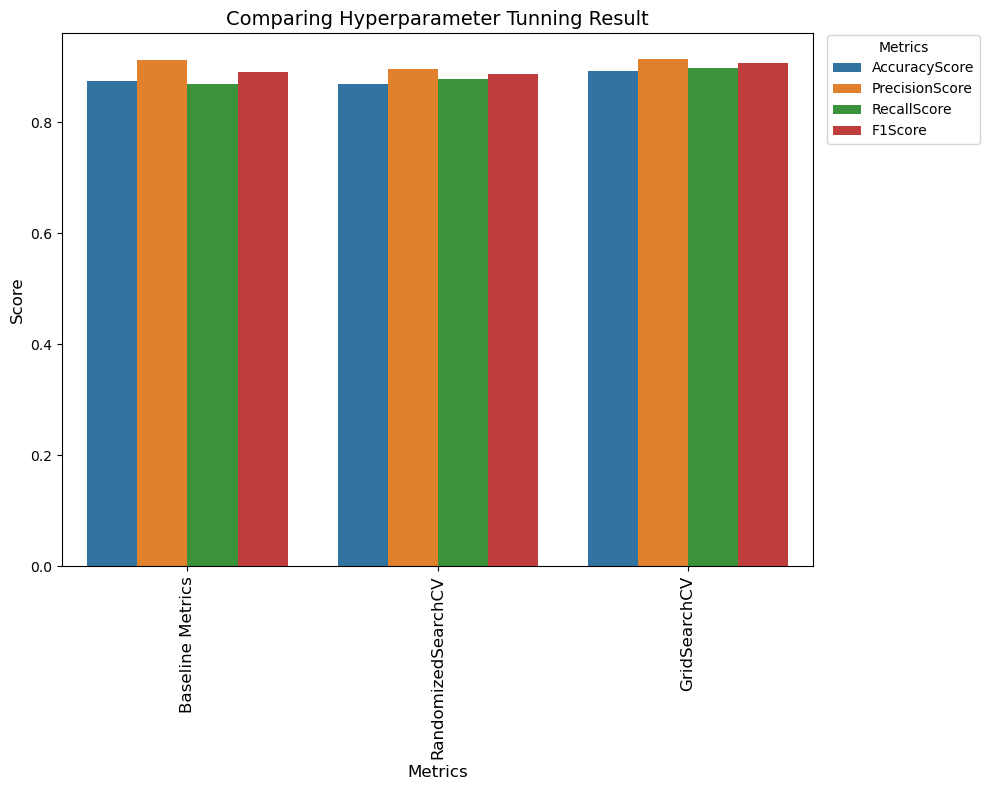

In [64]:
plt.figure(figsize=(10, 8))
sns.barplot(x='Metrics', y='Score', hue='Model', data=long_metrics)
plt.title('Comparing Hyperparameter Tunning Result', fontsize=14)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=90, fontsize=12)
plt.legend(title='Metrics', bbox_to_anchor=(1.01, 1.01))
plt.tight_layout()
plt.show()